In [225]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sklearn
import scipy
import os
import re

from scipy import stats
from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model


%matplotlib inline

# Methods to import data

#### Methods To Import Event Data

In [ ]:
'''
this function will take as an argument a file containing
the field index and description for every field in the data frames.
I will use this to create a template dataframe and to name the columns
because currently it is just using the first value as the column name
and it makes literally no sense at all.
'''
def shape_ev_data():
    #this file contains all the field descriptions
    field_descriptor_file_path = "csvFieldDescriptions.txt"
    
    #open the file and read it, adding each description to a list
    fields = open(field_descriptor_file_path, 'r')
    fieldInfo = []
    for field in fields:
        fieldInfo.append(field[2:].strip())
    fields.close() #close file
    return fieldInfo

In [ ]:
'''
This function takes as an argument the number of subframes to include
where each 'subframe' is a pandas data frame containing play by play
data for a team for a year. It will then return those subframes
concatenated together into one main data frame. Subframes is preset to 50
'''
def get_event_data(subframes=50):
    csvFiles = '../data/event_csv_files/'
    csv_paths = os.listdir(csvFiles)#Get the paths of all of the CSV files
    column_info = shape_ev_data()#get the information on each field
    data = pd.DataFrame(columns=column_info)#create an empty data frame
    individual_data = []#create a list to hold the smaller frames
    del individual_data[:]#clear the list just in case I've already been using it

    #make all the dataframes
    df = pd.DataFrame(columns=column_info) #define a temp frame
    for index, path in enumerate(csv_paths):#iterate over the list of paths
        #names=column_info is what names the columns
        df = pd.read_csv(str(csvFiles+path), names=column_info)#read a file into a csv
        individual_data.append(df)#add it to the list
        
        #this line here is what limits how much data you pull.
        #if you eneter -1 for subframes it'll skip this check and
        #generate all of the data
        if(subframes != -1):#if the passed parameter is -1, generate ALL data
            if(index==subframes):#stop when desired subframe # is reached
                break
    
    data = pd.concat(individual_data) #combining sub frames
    del individual_data[:] #dont wanna waste space
    return data#, individual_data

#### Method To Import Game Log Data

In [ ]:
#reading in all the game logs and appending the dataframe accordingly
def get_gl_data():
    GLData = pd.DataFrame()
    gls = [] #to hold smaller frames
    del gls[:] #clear it to be sure
    glogpath = '../data/GameLogs/' #path to the game logs
    headPath = glogpath+'game_log_header.csv' #get the column info
    header = pd.read_csv(headPath) #import the column info
    colInfo = header.columns #store it for later use
    start_year = 1950 #define starting year. gonna use this in path
    end_year = 17 #also for path
    for logFolder in os.listdir(glogpath):
        try:#catching non int cases
            y1 = int(logFolder[2:4]) ##first two of start yyyy
            y2 = int(logFolder[2:6]) ##full start year
            y3 = int(str(y1)+logFolder[-2:]) #full end year
        except:
            continue
        #now open the folder if the start year is between the dates in the name
        if(start_year<y3):
            newPath = glogpath+logFolder
            files = os.listdir(newPath)#get all the logs in the folder
            for file in files:#now check each file to make sure it's the righ year
                year = int(file[2:6])#get year of file
                if(year>=start_year):#if it's within the range we want
                    full_path = glogpath+logFolder+'/'+file #make full path
                    gls.append(pd.read_csv(full_path, names=colInfo))#append the frame
    GLData = pd.concat(gls) #combine the subframes into this one
    del gls[:] #not wasting space
    return GLData

#### Method To Import Park Information Data

In [ ]:
#this method will return an unedited dataframe of the park information
def get_park_data():
    parks = pd.DataFrame() #create empty frame
    path = '../data/ParkInfo/ParkCodes.TXT' #path to park data

    cols = ['PARKID','CITY','STATE'] #cols to import
    parks = pd.read_csv(path, usecols=cols) #import it as csv
    parks.columns = ['parkid','city','state'] #name cols
    parks['location'] = parks.city + ', ' + parks.state #easier to cross ref
    parks = parks.drop(['city','state'],axis=1)
    
    #parks['lat'] = 0
    #parks['lng'] = 0
    
    return parks #return

#### Method To Import City Data

In [ ]:
#this method imports data on cities in the us
def get_ct_data():
    cities = pd.DataFrame() #create empty frame
    path = '../data/ParkInfo/uscities.csv' #path
    
    #which columns to import
    cols = ['city','state_id','lat','lng',]
    
    #get park info but only read the cols i want
    cities = pd.read_csv(path, usecols=cols)
    
    cities.columns = ['city','state','lat','lng'] #rename cols
    cities['location'] = cities.city + ', ' + cities.state #for cross ref
    cities = cities.drop(['city','state'], axis=1) #drop old cols
    
    cities = cities.drop_duplicates(subset='location') #only one station per city
    
    return cities

#### Method To Import Station Data


In [ ]:
#imports the station data
def get_st_data():
    cols = ['id','lat','lng','elevation','state']
    stations = pd.DataFrame(columns=cols) #stations
    path = '../data/Weather/station_list.txt' #path to file
    formatted_path = '../data/Weather/formatted_station_list.txt'
    stations = open(path, 'r') #open weather stations
    f_stations = open(formatted_path,'w') #file to write to
    
    #reformat the weather station file so it's not this ridiculous format
    for line in stations: #for each line
        new = line[:41] #remove the end because that's all irrelevant
        new = re.sub('\s\s$', 'zz', new)#fake state col if it doesn't exist
        new = ','.join(new.split())#remove spaces and replace with commas
        new = new+'\n' #add a newline at the end
        f_stations.write(new) #write the formatted line
    f_stations.close() #close the file at the end
    
    #now set stations frame
    stations = pd.read_csv(formatted_path, names=cols)
    
    stations = stations.replace('zz',np.nan)#replace the zz
    print(stations.shape)
    stations = stations.dropna(subset=['state'],axis=0)#drop ones with state (not in us)
    
    return stations

#### Method To Import bgame Files

In [ ]:
#get cols of feature names for bgame files
def shape_gl_data():
    fn = open('bgameFeatureNames.TXT', 'r') #open file
    fnames = [] #to store names
    for feature in fn: #go over lines
        f = re.sub('[\(\[].*?[\)\]]', '', feature[5:]).strip() #strip it
        fnames.append(f) #add to list
    fn.close()#close file
    return fnames 

In [ ]:
#gets game log data from bgame
def get_gl2_data():
    csvFiles = '../data/game_csv_files/'
    csv_paths = os.listdir(csvFiles)#Get the paths of all of the CSV files
    column_info = shape_gl_data()#get the information on each field
    data = pd.DataFrame(columns=column_info)#create an empty data frame
    individual_data = []#create a list to hold the smaller frames
    del individual_data[:]#clear the list just in case I've already been using it

    #make all the dataframes
    df = pd.DataFrame(columns=column_info) #define a temp frame
    for index, path in enumerate(csv_paths):#iterate over the list of paths
        #names=column_info is what names the columns
        df = pd.read_csv(str(csvFiles+path), names=column_info)#read a file into a csv
        individual_data.append(df)#add it to the list
    
    data = pd.concat(individual_data) #combining sub frames
    del individual_data[:] #dont wanna waste space
    return data#, individual_data

# Data Preprocessing

Should probably turn these into functions so I can also preprocess the main dataset. or any of the data that I want to pass to it. Shouldn't be to hard to parameterize. I guess it's worth noting that all of these functions so far have been written with the event data in mind. They almost certainly will not work on the gamelog data. I'm gonna rename the functions to indicate what data they should be used on.

#### Function to see what fraction of the original size the pruned data is

In [ ]:
#this will just return how much memory pre, post and the percentage
def get_reduction(pre, post):
    a = np.sum(pre.memory_usage())
    b = np.sum(post.memory_usage())
    return a, b, b/a

#### Pruning

In [ ]:
#going to drop a lot of columns
def prune_ev_data(original_data, verbose=False):
    #indexes for columns to drop. Honestly i just looked at the field descriptions
    #and dropped mostly things like who was playing each position, where the ball 
    #was hit, the names of people who contributed to the play, etc
    ix = [12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 46, 47,
          49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
          67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86,
          87, 88, 89, 90, 91, 92, 93, 94, 95, 96
         ]
    #gonna turn those indexes into names just to ensure i drop the right
    #columns
    ixn = original_data.columns[ix]
    
    #verbose option
    if(verbose):
        print("Dropping Columns:\n")
        for col in ixn:
            print(col)
    
    pruned_data = original_data #copy data for pruned data
    #original_data_size = np.sum(original_data.memory_usage(deep=True)) #how big is the data

    #Prune Columns
    pruned_data = pruned_data.drop(pruned_data.columns[ix], axis=1) #prune columns
    
    return pruned_data

In [ ]:
#prune the game logs
def prune_gl_data(original_data, verbose=False):
    #columns to drop. Doing by index again because it'd be a huge hassle to
    #type hundreds of column names. I will convert the indices to col namse
    #and add a verbose flag to see what I've chosen to drop. Again,
    #i'm basically just reading the data description on retrosheet and doing
    #this by hand. In the future, it would be easier to only pull the data we 
    #need as opposed to pulling all and then pruning
    #gonna use lists to get ranges so i don't have to type tons of nums
    ix = [13, 14, 15, 4, 5, 7, 8]
    l1 = list(np.arange(78, 101, 1))
    l2 = list(np.arange(106, 161, 1))
    ix  = ix + l1 + l2 #concat these lists
    
    #get col names
    ixn = original_data.columns[ix]
    
    #verbose option
    if(verbose):
        print("Dropping Columns:\n")
        for col in ixn:
            print(col)
    
    pruned_data = original_data #copy data for pruned data
    
    #Prune Columns
    pruned_data = pruned_data.drop(pruned_data.columns[ix], axis=1) #prune columns
    
    return pruned_data

#### Adding Features

In [ ]:
#this method takes the event data and, for each event, adds a column for the
#team under which the play is filed, the date of the play (for weather)
#and the game of the day
def add_ev_metadata(event_data):
    #Adding in a bit more data on the team, date, game of day, and also field
    event_data['team'] = event_data['game id'].astype(str).str[:3]#storing the team
    event_data['date'] = event_data['game id'].astype(str).str[3:-1]#date
    event_data['game_of_day'] = event_data['game id'].astype(str).str[-1:]#which game of the day it is
    return event_data

In [ ]:
#takes in park data, city data, and station data respectively.
#adds the coordinates and respective weather station to each park entry
def add_pk_metadata(pdata, cdata, sdata):
    #adding coordinates
    pdata = pdata.merge(cdata, left_on='location', right_on='location', how='left')
    
    #now find the nearest weather station
    pdata['station'] = 'na'#create an empty station col
    combined = pd.DataFrame() #empty combined frame
    
    #just giving it a parkid to use as a placeholder
    sdata['parkid'] = 'zz'
    
    #defining the columns of the new frame
    #combining park and station data
    ids = pdata['parkid'].append(sdata['parkid'], ignore_index=True) #add this to frame
    lats = pdata['lat'].append(sdata['lat'], ignore_index=True) #add latitudes
    lngs = pdata['lng'].append(sdata['lng'], ignore_index=True) #and lngs
    stations = pdata['station'].append(sdata['id'], ignore_index=True) #adding a station col
    
    #adding these to the combined frame
    combined['lng'] = lngs
    combined['lat'] = lats
    combined['parkid'] = ids
    combined['station'] = stations
    
    print(pdata.head())
    
    return pdata
    
    #gonna use a nearest neighbors algorithm that uses lat and long
    #to find the single nearest neighbor to each point.
    #will use the combined cities and stations data so that it matches
    #a city with the nearest station. I'm using cities because there are multiple
    #parks per city, so they would just match with each other instead of a station.
    X = np.column_stack((combined['lat'],combined['lng']))
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    
    #only want to find the neighbors for the parks 
    #this is the first 252 rows
    X2 = X[:252]
    
    #get the distances and indices
    d, i  = nbrs.kneighbors(X)
    
    pairs = [] #pairs of indices for cities and stations in the combined frame
    for r in i: #for each set of neighbors
        found = False #if the best match hasn't been found
        for ix in r: #check each of the best pairs
            if(found): #if the best neighbor has been found break
                break
            if(ix>=252 and not found): #if the neighbor is NOT another city
                pairs.append([r[0],ix]) #add the pair
                found = True #mark that a station has been found
    
    return pdata, i

In [ ]:
pkdata2 = add_pk_metadata(pkdata, ctdata, stdata)
#pkdata2.shape

In [ ]:
#adding coordinates
pkdata = pkdata.merge(ctdata, left_on='location', right_on='location', how='left')

#now find the nearest weather station
pkdata['station'] = 'na'#create an empty station col

combined = pd.DataFrame() #empty combined frame
stdata['parkid'] = 'zz' #so i can add them to the frame and it's easier to separate

lngs = pkdata['lng'].append(stdata['lng'], ignore_index=True) #and lngs
locations = pkdata['parkid'].append(stdata['parkid'], ignore_index=True) #add this to frame
lats = pkdata['lat'].append(stdata['lat'], ignore_index=True) #add latitudes

combined['lat'] = lats
combined['lng'] = lngs
combined['locations'] = locations



#gonna use a nearest neighbors algorithm that uses lat and long
#to find the single nearest neighbor to each point.
#will use the combined cities and stations data so that it matches
#a city with the nearest station. I'm using cities because there are multiple
#parks per city, so they would just match with each other instead of a station.
X = np.column_stack((combined['lat'],combined['lng']))
#nbrs = NearestNeighbors(n_neighbors=4).fit(X)

X2 = X[:252]

#d, i  = nbrs.kneighbors(X2)
#print(i[:36][:])
#pairs = []
#for r in i:
#    found = False
#    for ix in r:
#        if(found):
#            break
#        if(ix>=252 and not found):
#            pairs.append([r[0],ix])
#            found = True
            
pkdata.columns

#### Converting Categorical Data to Ints

In [ ]:
#this function takes any categorical data that can be represented as
#ints and converts it. it also reduces all int columns
#to the smallest possible integer form
def reduce_ev_nums(original_data):
    redata = original_data #reduced event data

    #I noticed all the features I wanted to convert were all binary data for
    #flags and which hand people use. So gonna iterate through the features
    #and convert features with the word flag or hand
    for column in redata.columns:#go through the cols
        #if the feature name has hand or flag
        if(('hand' in column.lower()) or ('flag' in column.lower())):
            redata[column] = redata[column].astype('category')#set to cat

    #convert them to ints            
    cat_columns = redata.select_dtypes(['category']).columns #get cat cols
    redata[cat_columns] = redata[cat_columns].apply(lambda x: x.cat.codes) #cast to int
    
    #downcast all to smallest acceptable int size
    ints = redata.select_dtypes(include=['int']) #get any int cols
    ints = ints.apply(pd.to_numeric, downcast='unsigned') #downcast them
    
    #downcast floats
    floats = redata.select_dtypes(include=['float']) #get floats
    floats = floats.apply(pd.to_numeric,downcast='float') #downcast them
    
    #now replace the numeric columns with their reduced ones
    redata[ints.columns] = ints #replace with reduced ints
    redata[floats.columns] = floats #replace with reduced floats
    
    #retyped_data_size = np.sum(redata.memory_usage(deep=True)) #store size
    return redata

In [ ]:
#this function will reduce the numbers in the game log data
def reduce_gl_nums(original_data, verbose=False):
    redata = original_data #copy data
    
    #manually looked through at which object cols could be cast to ints and 
    #reduced. Converting some like player name would cause us to lose info
    #at the same time, we aren't really interested in specific pitchers so 
    #that may be a good idea to reduce them as well. future decisions.
    ixn = ['DayOfWeek','DayNight'] #names for verbose
    ix = [] #to store indices of names
    for i in ixn: #iterate over col names
        ix.append(original_data.columns.get_loc(i)) #get index from name
    
    #print names if verbose
    if(verbose):
        print("Removing Columns:\n")
        for col in ixn:
            print(col)
            
    #convert ints to categories
    for col in ixn:
        redata[col] = redata[col].astype('category')#cast to category
    
    #convert categories to ints
    cat_cols = redata.select_dtypes(['category']).columns #get cat cols
    redata[cat_cols] = redata[cat_cols].apply(lambda x: x.cat.codes) #to int
    
    #downcast ints
    ints = redata.select_dtypes(include=['int']) #get ints
    ints = ints.apply(pd.to_numeric,downcast='unsigned') #downcast them
    
    #downcast floats
    floats = redata.select_dtypes(include=['float']) #get floats
    floats = floats.apply(pd.to_numeric,downcast='float') #downcast them
    
    #now replace the numeric columns with their reduced ones
    redata[ints.columns] = ints #replace with reduced ints
    redata[floats.columns] = floats #replace with reduced floats
    
    return redata #return the reduced data

#### Putting It All Together

In [ ]:
# this function just combines the preprocessing steps so you don't have to
# it takes a dataframe and a frame type eg: ev for event, gl for game log,
# pk for park, wt for weather. It will then return the processed data and,
# if you pass verbose as True, it'll return the dataframe size at each step
# stored in a list
def process_data(data, data_type, verbose=False):
    sizes = [] #to store data sizes
    reduced = pd.DataFrame() #to store reduced data
    
    #store first mem usage for verbose
    sizes.append(np.sum(data.memory_usage(deep=True)))
    
    #process depending on data type
    if(data_type=='ev'): #event data
        reduced = prune_ev_data(data) #prune
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
        reduced = reduce_ev_nums(reduced) #downcast numerics
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
    elif(data_type=='gl'):
        reduced = prune_gl_data(data) #prune
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
        reduced = reduce_gl_nums(reduced) #downcast numerics
        sizes.append(np.sum(reduced.memory_usage(deep=True))) #verbose
    else:
        print("Please enter a valid data type.")
        return
    
    #return depending on verbose
    if(verbose): #return the sizes
        return reduced, sizes #like so
    else: #if they don't want verbose just return data
        return reduced

# Creating Data Frames and Processing Them

In [250]:
evdata = get_event_data(50) #get event data
gldata = get_gl_data() #get game log data
pkdata = get_park_data() #get park data
ctdata = get_ct_data() #get city data
stdata = get_st_data() #get the station data

gl2data = get_gl2_data()

In [197]:
#Here is an example of how to use the process data function
asize = evdata.memory_usage(deep=True)
reduced_evdata = process_data(evdata, 'ev')

In [198]:
gl2data.columns

Index([u'game id', u'date', u'game number', u'day of week', u'start time',
       u'DH used flag', u'day/night flag', u'visiting team', u'home team',
       u'game site', u'vis. starting pitcher', u'home starting pitcher',
       u'home plate umpire', u'first base umpire', u'second base umpire',
       u'third base umpire', u'left field umpire', u'right field umpire',
       u'attendance', u'PS scorer', u'translator', u'inputter', u'input time',
       u'edit time', u'how scored', u'pitches entered?', u'temperature',
       u'wind direction', u'wind speed', u'field condition', u'precipitation',
       u'sky', u'time of game', u'number of innings', u'visitor final score',
       u'home final score', u'visitor hits', u'home hits', u'visitor errors',
       u'home errors', u'visitor left on base', u'home left on base',
       u'winning pitcher', u'losing pitcher', u'save for', u'GW RBI',
       u'visitor batter 1', u'visitor position 1', u'visitor batter 2',
       u'visitor position 2', 

In [199]:
get = ['game id','day/night flag','attendance','temperature','wind direction',
      'wind speed','field condition','precipitation','sky']
weather = gl2data[get]

In [200]:
weather.shape

(66801, 9)

In [201]:
a = np.sum(asize)
b = np.sum(reduced_evdata.memory_usage(deep=True))

In [202]:
print(b/a)
reduced_evdata.shape

0


(284565, 33)

In [203]:
first_n_rows = 1000000
events = reduced_evdata.iloc[:-first_n_rows,:]

In [204]:
stdata = get_st_data() #get the station data
stdata.shape

(67278, 5)

# Analysis

In [ ]:
def batting_average_loc(evdata, feature, val):
    # Create new dataframe with data to calculate batting average
    oBatterData = evdata[['game id', 'batter', 'event type', 'batter event flag', 'ab flag', 'hit value','outs','balls','inning','strikes','pitcher hand','batter hand']].copy()
    
    #
    oBatterData =  oBatterData.loc[oBatterData.feature==val]
    
    # Calculate batters' at bats and hits per game
    BatterData = oBatterData.loc[(oBatterData['batter event flag'] == 1) & (oBatterData['ab flag'] == 1)]
    BatterData2 = BatterData.loc[(BatterData['batter event flag'] == 1) & (BatterData['ab flag'] == 1) & (BatterData['hit value'] > 0)]
    BatterData = BatterData.groupby(['game id', 'batter']).size().reset_index(name='AB')
    BatterData2 = BatterData2.groupby(['game id', 'batter']).size().reset_index(name='H')

    #BatterData.loc[(BatterData['batter event flag'] == 1) & (BatterData['ab flag'] == 1)]['hit value'].groupby(['batter'])

    BatterData3 = oBatterData.loc[(oBatterData['batter event flag'] == 1) & (oBatterData['ab flag'] == 1) & (oBatterData['hit value'] == 0)]
    BatterData3 = BatterData3.groupby(['game id', 'batter']).size().reset_index(name='strikeouts')

    bat3 = BatterData.merge(BatterData2, left_on=['batter','game id'], right_on=['batter','game id'], how='outer')
    bat3 = bat3.merge(BatterData3, left_on=['batter','game id'], right_on=['batter','game id'], how='outer')

    bat3['BA'] = bat3.apply(lambda row: row['H']/row['AB'],axis=1)

    bat3 = bat3.fillna(value=0, axis=1)
    
    return bat3

In [218]:
# Create new dataframe with data to calculate batting average
oBatterData = reduced_evdata[['game id', 'batter', 'event type', 'batter event flag', 'ab flag', 'hit value']].copy()

# Calculate batters' at bats and hits per game
BatterData = oBatterData.loc[(oBatterData['batter event flag'] == 1) & (oBatterData['ab flag'] == 1)]
BatterData2 = BatterData.loc[(BatterData['batter event flag'] == 1) & (BatterData['ab flag'] == 1) & (BatterData['hit value'] > 0)]
BatterData = BatterData.groupby(['game id', 'batter']).size().reset_index(name='AB')
BatterData2 = BatterData2.groupby(['game id', 'batter']).size().reset_index(name='H')

#BatterData.loc[(BatterData['batter event flag'] == 1) & (BatterData['ab flag'] == 1)]['hit value'].groupby(['batter'])

BatterData3 = oBatterData.loc[(oBatterData['batter event flag'] == 1) & (oBatterData['ab flag'] == 1) & (oBatterData['hit value'] == 0)]
BatterData3 = BatterData3.groupby(['game id', 'batter']).size().reset_index(name='strikeouts')

bat3 = BatterData.merge(BatterData2, left_on=['batter','game id'], right_on=['batter','game id'], how='outer')
bat3 = bat3.merge(BatterData3, left_on=['batter','game id'], right_on=['batter','game id'], how='outer')

bat3['BA'] = bat3.apply(lambda row: row['H']/row['AB'],axis=1)

bat3 = bat3.fillna(value=0, axis=1)

bat3.head()

,game id,batter,AB,H,strikeouts,BA
0,BOS195004180,battm101,5,0.0,5.0,0.00
1,BOS195004180,baueh101,4,1.0,3.0,0.25
2,BOS195004180,berry101,5,3.0,2.0,0.60
3,BOS195004180,browb105,1,0.0,1.0,0.00
4,BOS195004180,colej106,2,0.0,2.0,0.00


In [ ]:
data9 = EVdata.loc[data.inning==9]
data92 = data9[abs(data9['vis score']-data9['home score'])<2]#9th inning with two outs
x = data9['outs']
y = data9['RBI on play']
correlation = np.corrcoef(x, y)
EVdata["outOrHit"] = EVdata.apply(lambda row: 1 if 
                                (row["event type"]==2 or 
                                row["event type"]==3) else
                                2 if 
                                row["event type"]==20 else
                                3 if
                                row["event type"]==21 else
                                4 if
                                row["event type"]==22 else
                                5 if
                                row["event type"]==23
                                else None, axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(EVdata.loc[data.outs==2].outOrHit.dropna(), facecolor='green')
ax.set_xlabel("Event Value\nFigure 2")
ax.set_ylabel("Frequency")
ax.set_xticks(np.arange(6))
ax.set_title("Frequency of Event Values with 2 Outs")
fig.subplots_adjust(hspace=.5)
plt.show()

In [ ]:
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(4,12), nrows=3, ncols=1)
for i in data.loc[data.inning==9].outs.unique():
    EVdata.loc[(data.inning==9) & (data.outs==i)].outOrHit.hist(ax=ax[i])
    ax[i].set_xlabel("Event Value\nFigure 1")
    ax[i].set_ylabel("Frequency")
    ax[i].set_xticks(np.arange(6))
    ax[i].set_title("Frequency of Event Values with {0} Outs".format(i))
fig.subplots_adjust(hspace=.5)
plt.suptitle("Frequency of Event Values with 0, 1, and 2 Outs")
plt.show()

 y = 0.000290051807775 * x + 0.234602709593
Mean squared error: 0.07
Variance score: -0.00


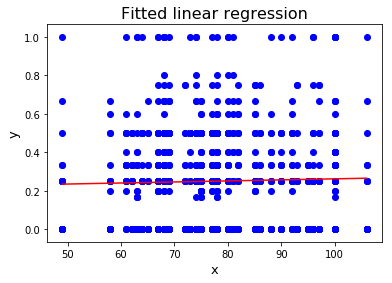

In [248]:
BattingAverageDF = bat3
regr = linear_model.LinearRegression()
temperature = weather[['game id', 'temperature']].copy()
temperature = temperature[temperature['temperature'] != 0]
TempAnalysis = temperature.merge(BattingAverageDF, left_on='game id', right_on='game id', how='inner')
x = TempAnalysis['temperature']
y = TempAnalysis['BA']
max_x = max(x)
min_x = min(x)
train_data_X = map(lambda x: [x], list(x[:-1000]))
train_data_Y = list(y[:-1000])
test_data_X = map(lambda x: [x], list(x[-1000:]))
test_data_Y = list(y[-1000:])
regr.fit(train_data_X, train_data_Y)
m = regr.coef_[0]
b = regr.intercept_
print(' y = {0} * x + {1}'.format(m, b))

plt.scatter(test_data_X, test_data_Y, color='blue')
plt.plot([min_x, max_x], [b, m*max_x + b], 'r')
plt.title('Fitted linear regression', fontsize=16)
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)

print("Mean squared error: %.2f" % np.mean((regr.predict(test_data_X) - test_data_Y) ** 2))
print('Variance score: %.2f' % regr.score(test_data_X, test_data_Y))

## Trying To Make Some Performance Metrics